Fechner K = -0.400000  (same=6, different=14, ties=0)
Pearson r = -0.569894
Pearson 95% CI = [-0.808518, -0.170320]
Spearman rho = -0.539157
Kendall tau-b = -0.436176   (concordant=52, discordant=134, ties_x=3, ties_y=1)


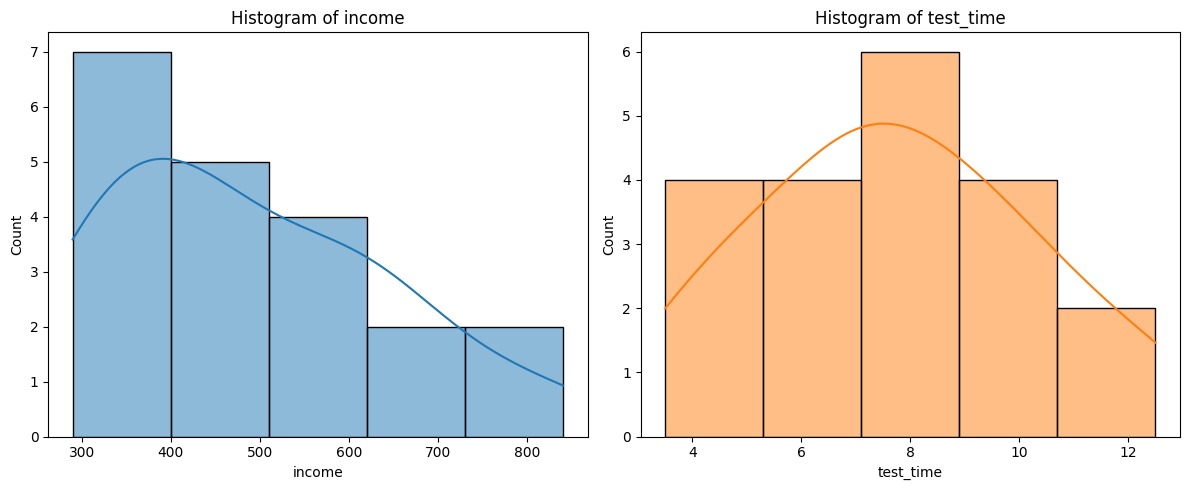

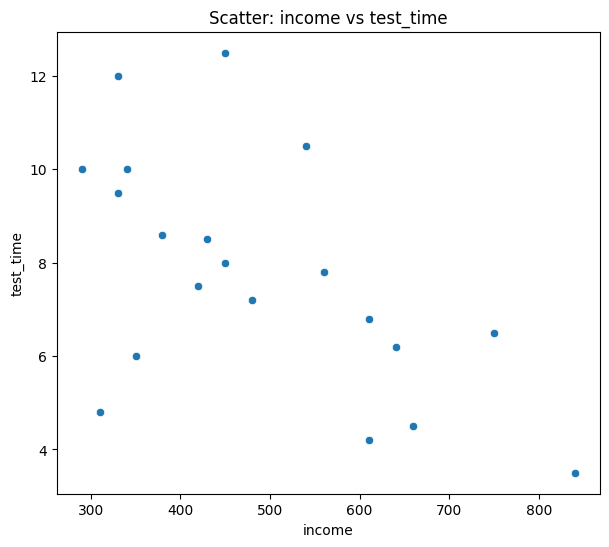

Linear coeffs: w1=-0.009169, w0=12.208888, MSE=4.083128, R2=0.324779
Quadratic coeffs: w2=-0.000018, w1=0.009697, w0=7.601723, MSE=3.905364, R2=0.354176
Hyperbolic coeffs: w1=1832.346540, w0=3.614860, MSE=4.579035, R2=0.242772
Exponential coeffs: w1=0.998654, w0=14.121573, MSE=4.305486, R2=0.288008

Model ranking by MSE (low->high):
 - quadratic: MSE=3.905364, R2=0.354176, params=[-1.75912318e-05  9.69722043e-03  7.60172261e+00]
 - linear: MSE=4.083128, R2=0.324779, params=[-9.16865523e-03  1.22088881e+01]
 - exponential: MSE=4.305486, R2=0.288008, params=[ 0.99865437 14.12157347]
 - hyperbolic: MSE=4.579035, R2=0.242772, params=[1832.34654048    3.6148599 ]

Model ranking by R2 (high->low):
 - quadratic: R2=0.354176, MSE=3.905364, params=[-1.75912318e-05  9.69722043e-03  7.60172261e+00]
 - linear: R2=0.324779, MSE=4.083128, params=[-9.16865523e-03  1.22088881e+01]
 - exponential: R2=0.288008, MSE=4.305486, params=[ 0.99865437 14.12157347]
 - hyperbolic: R2=0.242772, MSE=4.579035, para

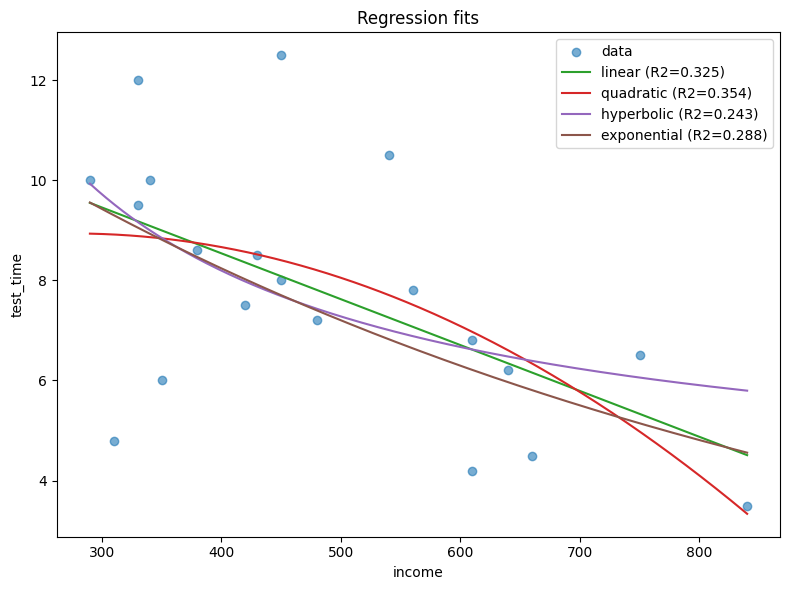

In [11]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import namedtuple



df = pd.read_csv('/content/students_simple.csv')
x = df['income'].astype(float).values
y = df['test_time'].astype(float).values
n = len(x)



def mean(a):
    return a.sum() / len(a)
def var(a, ddof=0):
    return ((a - mean(a))**2).sum() / (len(a) - ddof)
def mse(y_true, y_pred):
    return ((y_true - y_pred)**2).mean()
def r2_score(y_true, y_pred):
    ss_res = ((y_true - y_pred)**2).sum()
    ss_tot = ((y_true - y_true.mean())**2).sum()
    return 1 - ss_res/ss_tot



def fechner_k(x, y):
    xm = mean(x); ym = mean(y)
    same = 0
    diff = 0
    ties = 0
    for xi, yi in zip(x, y):
        sx = 0 if xi == xm else (1 if xi > xm else -1)
        sy = 0 if yi == ym else (1 if yi > ym else -1)
        if sx == 0 or sy == 0:
            ties += 1
            continue
        if sx == sy:
            same += 1
        else:
            diff += 1
    K = (same - diff) / n
    return K, same, diff, ties
K, same_cnt, diff_cnt, tie_cnt = fechner_k(x, y)
print(f"Fechner K = {K:.6f}  (same={same_cnt}, different={diff_cnt}, ties={tie_cnt})")



def pearson_r(x, y):
    xm, ym = mean(x), mean(y)
    num = ((x - xm)*(y - ym)).sum()
    den = math.sqrt(((x - xm)**2).sum() * ((y - ym)**2).sum())
    return num/den
r = pearson_r(x, y)
print(f"Pearson r = {r:.6f}")



def pearson_ci(r, n, alpha=0.05):
    z = 0.5 * math.log((1+r)/(1-r))
    se = 1 / math.sqrt(n - 3)
    z_crit = 1.96
    z_lo, z_hi = z - z_crit*se, z + z_crit*se
    r_lo = (math.exp(2*z_lo) - 1) / (math.exp(2*z_lo) + 1)
    r_hi = (math.exp(2*z_hi) - 1) / (math.exp(2*z_hi) + 1)
    return r_lo, r_hi
r_lo, r_hi = pearson_ci(r, n)
print(f"Pearson 95% CI = [{r_lo:.6f}, {r_hi:.6f}]")



def spearman_rho(x, y):
    def ranks(a):
        order = np.argsort(a)
        r = np.empty(len(a), dtype=float)
        i = 0
        while i < len(a):
            j = i
            while j+1 < len(a) and a[order[j+1]] == a[order[i]]:
                j += 1
            avg_rank = 0.5*(i + j) + 1
            for k in range(i, j+1):
                r[order[k]] = avg_rank
            i = j + 1
        return r
    rx, ry = ranks(x), ranks(y)
    return pearson_r(rx, ry)
rho = spearman_rho(x, y)
print(f"Spearman rho = {rho:.6f}")



def kendall_tau(x, y):
    n = len(x)
    concordant = 0
    discordant = 0
    ties_x = 0
    ties_y = 0
    for i in range(n-1):
        xi, yi = x[i], y[i]
        for j in range(i+1, n):
            xj, yj = x[j], y[j]
            dx = xi - xj
            dy = yi - yj
            if dx == 0 and dy == 0:
                continue
            if dx * dy > 0:
                concordant += 1
            elif dx * dy < 0:
                discordant += 1
            else:
                if dx == 0:
                    ties_x += 1
                if dy == 0:
                    ties_y += 1
    denom = math.sqrt((concordant + discordant + ties_x) * (concordant + discordant + ties_y))
    tau_b = (concordant - discordant) / denom if denom != 0 else 0.0
    return tau_b, concordant, discordant, ties_x, ties_y
tau, conc, disc, tx, ty = kendall_tau(x, y)
print(f"Kendall tau-b = {tau:.6f}   (concordant={conc}, discordant={disc}, ties_x={tx}, ties_y={ty})")



plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(x, kde=True, bins=5, color='C0')
plt.title('Histogram of income'); plt.xlabel('income')
plt.subplot(1,2,2)
sns.histplot(y, kde=True, bins=5, color='C1')
plt.title('Histogram of test_time'); plt.xlabel('test_time')
plt.tight_layout(); plt.show()
plt.figure(figsize=(7,6))
sns.scatterplot(x=x, y=y)
plt.title('Scatter: income vs test_time'); plt.xlabel('income'); plt.ylabel('test_time')
plt.show()




Model = namedtuple('Model', ['name','predict','params','mse','r2','p'])
models = []



X_lin = np.vstack([x, np.ones_like(x)]).T
w_lin = np.linalg.lstsq(X_lin, y, rcond=None)[0]
y_pred_lin = X_lin.dot(w_lin)
mse_lin = mse(y, y_pred_lin)
r2_lin = r2_score(y, y_pred_lin)
models.append(Model('linear', lambda xx: w_lin[0]*xx + w_lin[1], w_lin.copy(), mse_lin, r2_lin, 2))
print(f"Linear coeffs: w1={w_lin[0]:.6f}, w0={w_lin[1]:.6f}, MSE={mse_lin:.6f}, R2={r2_lin:.6f}")



X_quad = np.vstack([x**2, x, np.ones_like(x)]).T
w_quad = np.linalg.lstsq(X_quad, y, rcond=None)[0]
y_pred_quad = X_quad.dot(w_quad)
mse_quad = mse(y, y_pred_quad)
r2_quad = r2_score(y, y_pred_quad)
models.append(Model('quadratic', lambda xx: w_quad[0]*xx**2 + w_quad[1]*xx + w_quad[2], w_quad.copy(), mse_quad, r2_quad, 3))
print(f"Quadratic coeffs: w2={w_quad[0]:.6f}, w1={w_quad[1]:.6f}, w0={w_quad[2]:.6f}, MSE={mse_quad:.6f}, R2={r2_quad:.6f}")



mask_nonzero = (x != 0)
z = 1.0/x[mask_nonzero]
y_h = y[mask_nonzero]
X_hyp = np.vstack([z, np.ones_like(z)]).T
w_hyp = np.linalg.lstsq(X_hyp, y_h, rcond=None)[0]
def pred_h(xx):
    return w_hyp[0] / xx + w_hyp[1]
y_pred_h = np.array([pred_h(xx) if xx!=0 else np.nan for xx in x])
mse_hyp = mse(y[~np.isnan(y_pred_h)], y_pred_h[~np.isnan(y_pred_h)])
r2_hyp = r2_score(y[~np.isnan(y_pred_h)], y_pred_h[~np.isnan(y_pred_h)])
models.append(Model('hyperbolic', pred_h, w_hyp.copy(), mse_hyp, r2_hyp, 2))
print(f"Hyperbolic coeffs: w1={w_hyp[0]:.6f}, w0={w_hyp[1]:.6f}, MSE={mse_hyp:.6f}, R2={r2_hyp:.6f}")



mask_pos = (y > 0)
Xp = x[mask_pos]
Yp = y[mask_pos]
A = np.vstack([Xp, np.ones_like(Xp)]).T
lnY = np.log(Yp)
a_b = np.linalg.lstsq(A, lnY, rcond=None)[0]
a, b = a_b[0], a_b[1]
w1_exp = math.exp(a)
w0_exp = math.exp(b)
def pred_exp(xx):
    return w0_exp * (w1_exp**xx)
y_pred_exp = np.array([pred_exp(xx) for xx in x])
mse_exp = mse(y[mask_pos], y_pred_exp[mask_pos])
r2_exp = r2_score(y[mask_pos], y_pred_exp[mask_pos])
models.append(Model('exponential', pred_exp, np.array([w1_exp, w0_exp]), mse_exp, r2_exp, 2))
print(f"Exponential coeffs: w1={w1_exp:.6f}, w0={w0_exp:.6f}, MSE={mse_exp:.6f}, R2={r2_exp:.6f}")



xx_plot = np.linspace(x.min(), x.max(), 400)
plt.figure(figsize=(8,6))
plt.scatter(x, y, label='data', alpha=0.6)
colors = {'linear':'C2', 'quadratic':'C3', 'hyperbolic':'C4', 'exponential':'C5'}
for m in models:
    y_plot = np.array([m.predict(xx) for xx in xx_plot])
    plt.plot(xx_plot, y_plot, label=f"{m.name} (R2={m.r2:.3f})", color=colors[m.name])
plt.xlabel('income')
plt.ylabel('test_time')
plt.title('Regression fits')
plt.legend()
plt.tight_layout()



models_sorted_mse = sorted(models, key=lambda mm: mm.mse)
models_sorted_r2 = sorted(models, key=lambda mm: mm.r2, reverse=True)
best_by_mse = models_sorted_mse[0]
worst_by_mse = models_sorted_mse[-1]
best_by_r2 = models_sorted_r2[0]
worst_by_r2 = models_sorted_r2[-1]
print("\nModel ranking by MSE (low->high):")
for mm in models_sorted_mse:
    print(f" - {mm.name}: MSE={mm.mse:.6f}, R2={mm.r2:.6f}, params={mm.params}")
print("\nModel ranking by R2 (high->low):")
for mm in models_sorted_r2:
    print(f" - {mm.name}: R2={mm.r2:.6f}, MSE={mm.mse:.6f}, params={mm.params}")



def model_sse(model):
    y_pred = np.array([model.predict(xx) for xx in x])
    mask = ~np.isnan(y_pred)
    return ((y[mask] - y_pred[mask])**2).sum(), mask.sum()
def fisher_test(model_small, model_big):
    sse_small, n_small = model_sse(model_small)
    sse_big, n_big = model_sse(model_big)
    p_small = model_small.p
    p_big = model_big.p
    if p_big <= p_small:
        model_small, model_big = model_big, model_small
        sse_small, sse_big = sse_big, sse_small
        p_small, p_big = p_big, p_small
    df_num = p_big - p_small
    df_den = n - p_big
    F = ((sse_small - sse_big)/df_num) / (sse_big/df_den)
    return F, df_num, df_den, sse_small, sse_big
F_mse, dfn_mse, dfd_mse, sse_w, sse_b = fisher_test(worst_by_mse, best_by_mse)
print(f"\nF-test (worst_by_mse vs best_by_mse): F={F_mse:.6f}, df_num={dfn_mse}, df_den={dfd_mse}")
F_r2, dfn_r2, dfd_r2, sse_w2, sse_b2 = fisher_test(worst_by_r2, best_by_r2)
print(f"F-test (worst_by_r2 vs best_by_r2): F={F_r2:.6f}, df_num={dfn_r2}, df_den={dfd_r2}")


try:
    from scipy.stats import f
    p_mse = 1 - f.cdf(F_mse, dfn_mse, dfd_mse)
    p_r2 = 1 - f.cdf(F_r2, dfn_r2, dfd_r2)
    print(f"P-values: MSE-p={p_mse:.6e}, R2-p={p_r2:.6e}")
except Exception:
    pass



print("\n--- Final summary ---")
print(f"n = {n}")
print(f"Fechner eta = {K:.6f}")
print(f"Pearson r = {r:.6f}, 95% CI = [{r_lo:.6f}, {r_hi:.6f}]")
print(f"Spearman rho = {rho:.6f}")
print(f"Kendall tau-b = {tau:.6f}")
print("\nModels summary (name: MSE, R2, params):")
for mm in models:
    print(f" - {mm.name}: MSE={mm.mse:.6f}, R2={mm.r2:.6f}, params={mm.params}")
print("\nBest by MSE:", best_by_mse.name)
print("Worst by MSE:", worst_by_mse.name)
print("Best by R2:", best_by_r2.name)
print("Worst by R2:", worst_by_r2.name)


Общее впечатление: выявил обратную зависимость между доходом студента и временем, затраченным на прохождение теста; что, вообще говоря, имеет прикладной смысл.

Давайте посмотрим корреляционные меры:
1. По Фехнеру, имеем -0.4, что указывает на умеренную обратную связь, но не более
2. По Пирсону, имеем -0.569894, что также указывает на умеренную обратную связь, но стоит понимать, что так мы рассматриваем только линейную взаимосвязь
3. По Спирману, имеем -0.539157, что также указывает на умеренную обратную связь, если рассматривать такую связь как монотонную
4. По Кендаллу, имеем -0.436176; выведем формулы для вероятностей согласованности, имеем: ~28.19%, что также указывает на достаточно умеренную обратную связь

Примечательно также и рассмотрение доверительного интервала по Пирсону: интервал исключает беззнаковое значение, а значит и подтверждает свидетельство наличия линейной взаимосвязи.